In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [6]:
vocab_size

27

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,  Y_train  = build_dataset(words[:n1])     # 80%
X_dev, Y_dev = build_dataset(words[n1:n2])   # 10%
X_test,  Y_test  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [20]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 25.5262
  10000/ 200000: 1.8644
  20000/ 200000: 2.1724
  30000/ 200000: 2.3769
  40000/ 200000: 2.7019
  50000/ 200000: 2.1173
  60000/ 200000: 2.7660
  70000/ 200000: 2.3996
  80000/ 200000: 1.9732
  90000/ 200000: 2.5869
 100000/ 200000: 2.3589
 110000/ 200000: 2.1763
 120000/ 200000: 2.0617
 130000/ 200000: 1.7896
 140000/ 200000: 2.5402
 150000/ 200000: 2.2238
 160000/ 200000: 1.9641
 170000/ 200000: 2.0778
 180000/ 200000: 2.4476
 190000/ 200000: 1.7866


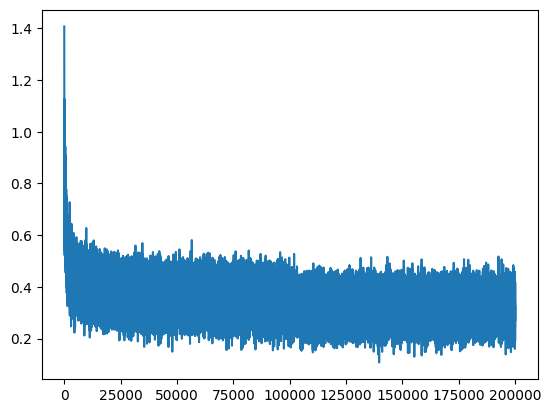

In [21]:
plt.plot(lossi)

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1236934661865234
val 2.1849231719970703


In [23]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ... and until we meet the 0th character again, 
    while True:
        embeddings = C[torch.tensor([context])] # (1, blocksize , d) # we're going to embed the current context using the embedding table C; usually here, the first dimension was the size of the training set, but here we're only using a single example that we're generating
        h = torch.tanh(embeddings.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and sum them to one and as with cross_entropy, it is careful so there's no overflows
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # once we have the probabilities, we sample from them, using multinomial to get our next index and then
        
        context = context[1:] + [ix] # we shift our the context window to append the index and record it
        out.append(ix)
        # if we sample the special token '.', break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # we decode all the integers to strings and print them out

montalmyah.
seel.
nihayla.
rethrushadrie.
caderidieliigh.
poren.
eden.
van.
narah.
tylor.
kalin.
shrenzi.
hiriel.
kindreelynn.
nocalyn.
breyddi.
jamell.
els.
kayshianny.
mahil.


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 25.5262
  10000/ 200000: 1.8644
  20000/ 200000: 2.1724
  30000/ 200000: 2.3769
  40000/ 200000: 2.7019
  50000/ 200000: 2.1173
  60000/ 200000: 2.7660
  70000/ 200000: 2.3996
  80000/ 200000: 1.9732
  90000/ 200000: 2.5869
 100000/ 200000: 2.3589
 110000/ 200000: 2.1763
 120000/ 200000: 2.0617
 130000/ 200000: 1.7896
 140000/ 200000: 2.5402
 150000/ 200000: 2.2238
 160000/ 200000: 1.9641
 170000/ 200000: 2.0778
 180000/ 200000: 2.4476
 190000/ 200000: 1.7866


There's multiple things wrong with it. At the 0th iteration, there's loss ~25, whic hrapidly comes down to roughly 2 or so. <br>
This tell that the initialization os all messed up. You can calculate what to expect at this step in time. 

In [26]:
# There's 27 characters, so we would like is 1/27, and then the loss is negative log probability
-torch.tensor(1/27).log()

tensor(3.2958)

what's happening right now is that at initialization the neural net is creating probability distributions that are all messed up some characters are very confident and some characters are very not confident. <br>
basically what's happening is that the network is very confidently wrong

In [27]:
# 4D example of the issue
# we have 4 characters; the logits that come out of the NN are very close to zero
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [28]:
# if we manipulate the logits, we'll be changing the loss
# if we are assigning the correct probability at the initialization, by chance, to the correct label, and we get a very low loss
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [29]:
# if we manipulate the logits, we'll be changing the loss
# but it is much more likely we get something like
logits = torch.tensor([0.0, 5.0, .0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [33]:
# if we manipulate the logits, we'll be changing the loss

#logits = torch.tensor([0.0, 5.0, .0, 0.0])
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([-0.4234,  0.5427, -0.3130,  0.2737]),
 tensor([0.1481, 0.3891, 0.1654, 0.2974]),
 tensor(1.7995))

In [38]:
# if we manipulate the logits, we'll be changing the loss

#logits = torch.tensor([0.0, 5.0, .0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([-11.6389,   3.6007,  -2.7594,   7.9979]),
 tensor([2.9277e-09, 1.2162e-02, 2.1030e-05, 9.8782e-01]),
 tensor(10.7695))

In [47]:
# you see how because these are more extreme values it's very unlikely that you're going to be guessing the correct bucket and then you're confidently wrong and recording very high loss if your lodges are coming out even more extreme

#logits = torch.tensor([0.0, 5.0, .0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([27.8283, 10.3973,  2.3538,  1.5132]),
 tensor([1.0000e+00, 2.6902e-08, 8.6406e-12, 3.7280e-12]),
 tensor(25.4746))

In [51]:
# you see how because these are more extreme values it's very unlikely that you're going to be guessing the correct bucket and then you're confidently wrong and recording very high loss if your lodges are coming out even more extreme

logits = torch.randn(4) * 100 # <-- extreme logits
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # it doesn;t matter if the label is 2, or 3 or 1 or 0 because it's a uniform distribution
logits, probs, loss

(tensor([-156.0620,  -77.4451,  -94.6319,  134.3531]),
 tensor([0., 0., 0., 1.]),
 tensor(inf))

### Fix initialization

In [53]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [54]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 25.5262


In [56]:
# priting the first row
# we can see that they have quite extreme values
# that's what makes the loss get very high, what's creating the fake confidence

# these logits should be much closer to zero.
logits[0]

tensor([  0.1576,  -2.3268,  -9.4740,  -6.7461,  13.7372, -10.4907,  -5.7905,
         10.7337,  14.0784,   4.3245,   1.9208, -14.9805,  14.0306, -10.9357,
          6.7341,   8.2830, -10.7423,  -4.5829, -14.5833, -16.0124,   7.2890,
         21.8017,  -3.0413, -20.3502,   5.5049, -13.1844,  -6.8645],
       grad_fn=<SelectBackward0>)

In [9]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # we scale down W2, you don't want the hidden layers to be set to zero
b2 = torch.randn(vocab_size,                      generator=g) * 0 # we basically want here the bias to be 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [59]:
W2, b2

(tensor([[ 0.0726,  0.1495, -0.1501,  ...,  0.0696,  0.0777, -0.0168],
         [ 0.0673, -0.0604, -0.0615,  ...,  0.0390,  0.0126,  0.1279],
         [ 0.1017,  0.0072,  0.0350,  ...,  0.0424,  0.0272,  0.0891],
         ...,
         [-0.2109, -0.0835,  0.0390,  ..., -0.1019,  0.0006,  0.0487],
         [-0.0345,  0.0279, -0.1516,  ...,  0.0090, -0.0675, -0.0690],
         [ 0.0302, -0.0987, -0.0026,  ...,  0.0233,  0.0254, -0.0514]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., -0., 0., 0., -0., -0., -0., 0., 0., 0., 0., -0., 0., 0., -0., 0., -0., 0., 0.,
         0., -0., -0.], requires_grad=True))

In [60]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.9789


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 4.2326
  10000/ 200000: 2.1403
  20000/ 200000: 2.4720
  30000/ 200000: 2.5577
  40000/ 200000: 2.0154
  50000/ 200000: 2.4307
  60000/ 200000: 2.3385
  70000/ 200000: 2.0680
  80000/ 200000: 2.2665
  90000/ 200000: 2.1172
 100000/ 200000: 1.9299
 110000/ 200000: 2.0629
 120000/ 200000: 1.8901
 130000/ 200000: 2.3980
 140000/ 200000: 2.2826
 150000/ 200000: 2.1250
 160000/ 200000: 1.8469
 170000/ 200000: 1.7627
 180000/ 200000: 1.9119
 190000/ 200000: 1.8235


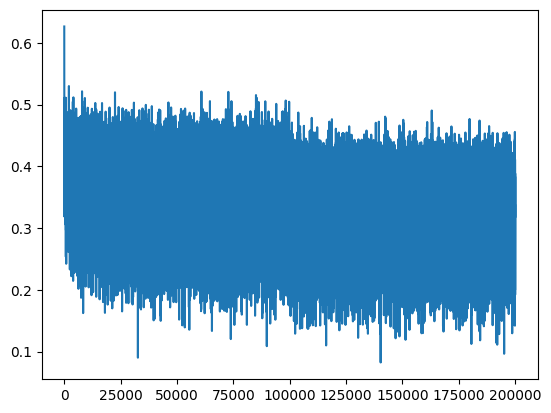

In [11]:
# what we expect, the loss doesn't look like a hockey stick 
plt.plot(lossi)

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (X_train, Y_train),
    'validation': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  embeddings = C[x] # (N, block_size, n_embd)
  embcat = embeddings.view(embeddings.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1

  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('validation')

train 2.0681493282318115
validation 2.132511854171753


### Let's move to fixing the secodn problem

In [8]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # we scale down W2, you don't want the hidden layers to be set to zero
b2 = torch.randn(vocab_size,                      generator=g) * 0 # we basically want here the bias to be 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


There's a deeper problem lurking in the hidden states. The logits are now ok, but the problem is with 'h'

In [19]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  embeddings = C[Xb] # embed the characters into vectors
  embcat = embeddings.view(embeddings.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  break

      0/ 200000: 4.2326


In [21]:
# You see how many of the elements are 1 or -1?
# tanh is a squashing function, it take arbitrary numbers and it squashes them into a range of [-1, 1] and it does this smoothly.
h.shape, h

(torch.Size([32, 200]),
 tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
         [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
         [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
         ...,
         [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
         [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
         [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
        grad_fn=<TanhBackward0>))

In [22]:
h.view(-1).shape, h.view(-1)

(torch.Size([6400]),
 tensor([ 0.8100, -0.8997, -0.9993,  ..., -0.1266,  1.0000,  1.0000],
        grad_fn=<ViewBackward0>))

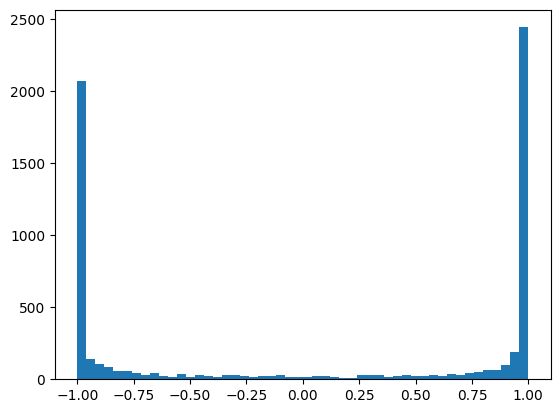

In [24]:
# we use semicolon to supress a bunch of output, we put the numbers in 50 bins
# we see that most values take -1 and 1..tanh is very active
plt.hist(h.view(-1).tolist(), 50);

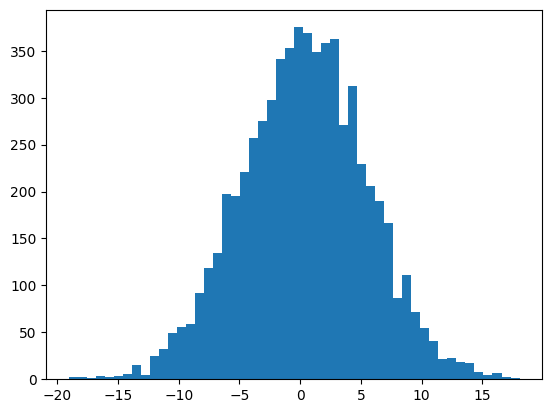

In [26]:
# we can see the distribution of these preactivations are very broad..numbers between -15 and 15..lots of numbers take extreme values
# this is not something what we want
plt.hist(hpreact.view(-1).tolist(), 50);

In [9]:
# 
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  embeddings = C[Xb] # embed the characters into vectors
  embcat = embeddings.view(embeddings.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  break

      0/ 200000: 4.2326


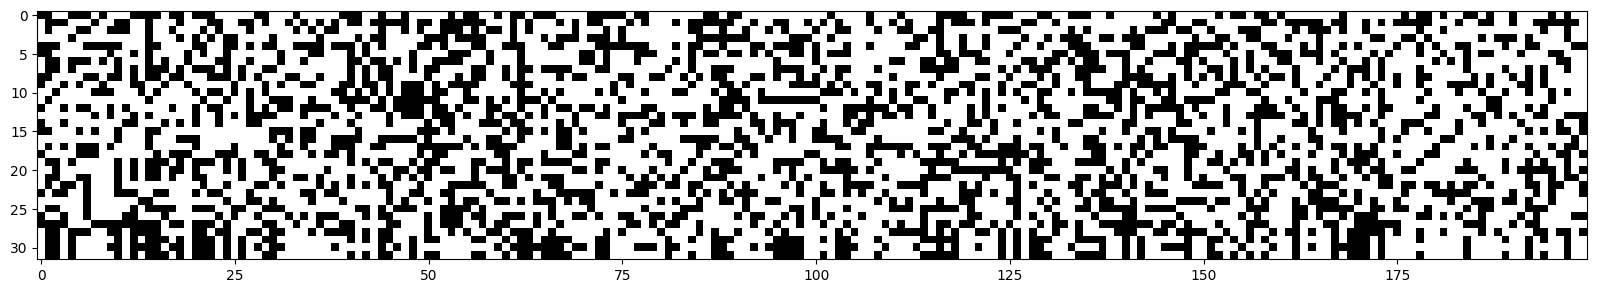

In [11]:
# alot of these squares are white, that tells us that all these tanh neurons, they're in the flat tail in all these cases.
# so for any one of these 200 neurons, if it was that case that the whole colums was white = dead neuron
# dead neuron means that where the initialization of the weights and biases could be such that no single example ever activates this tanh, it will never learn
# we do have some examples that activate them in the active part of the tanh and, therefore some gradients will flow through and these neurons will learn
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [17]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # this makes the dead neurons chance to 0
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # we scale down W2, you don't want the hidden layers to be set to zero
b2 = torch.randn(vocab_size,                      generator=g) * 0 # we basically want here the bias to be 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [18]:
# how to fix this?
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  embeddings = C[Xb] # embed the characters into vectors
  embcat = embeddings.view(embeddings.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  break

      0/ 200000: 3.3135


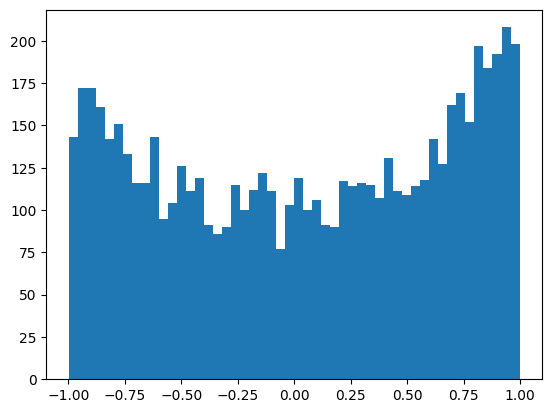

In [21]:
plt.hist(h.view(-1).tolist(), 50);

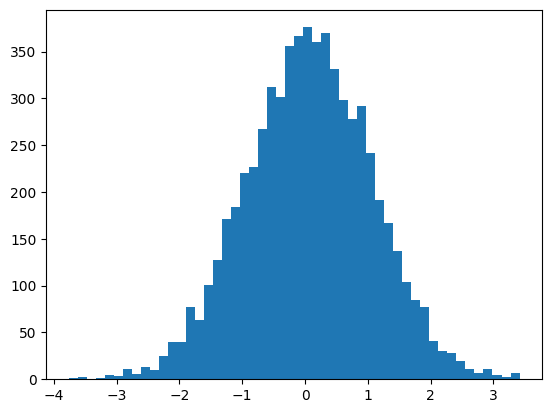

In [19]:
plt.hist(hpreact.view(-1).tolist(), 50);

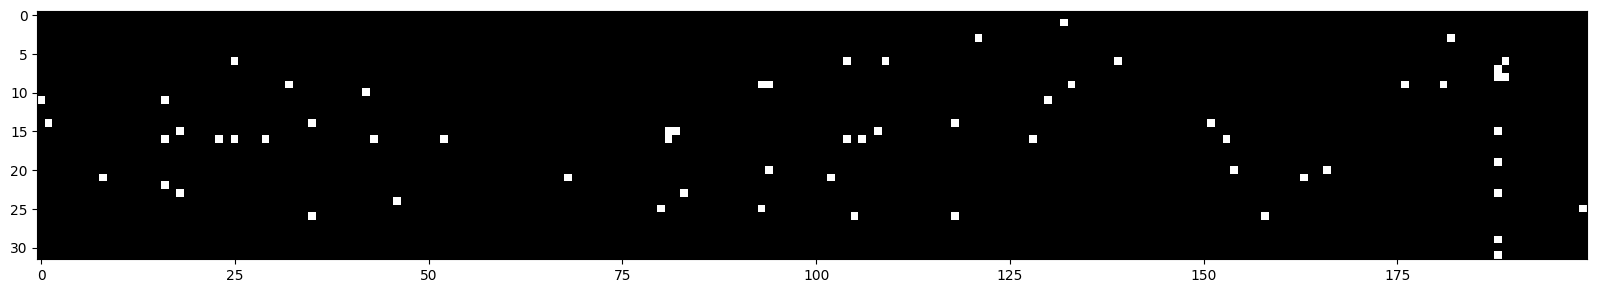

In [20]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [22]:
# how to fix this?
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  embeddings = C[Xb] # embed the characters into vectors
  embcat = embeddings.view(embeddings.shape[0], -1) # concatenate the vectors

  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


In [23]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (X_train, Y_train),
    'validation': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  embeddings = C[x] # (N, block_size, n_embd)
  embcat = embeddings.view(embeddings.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1

  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('validation')

train 2.0357086658477783
validation 2.102949380874634


In [ ]:
# loss log history

# original:
# train 2.123693466
# validation 2.18492317

# fixed softmax being confidently wrong:
# train 2.068149
# validation 2.18492317

# fixed tanh layer too saturated at init:
# train 2.0355966
# validation 2.1029493808

### Calculating the init scale: Kaiming init